In [90]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
from src.leachSFtree import leachSFClusteringJoin, leachSFClusteringTreeJoin
from src.mst_prim import prim_mst, create_routes_dict
import src.util as util
import src.topology as topology
import networkx as nx
from src.nova_join import Operator, OperatorType, NovaSolver
from src.util import log_opt_label, coordinator_label, worker_label, centroid_label, ch_label, join_label
from src.cardinalities import create_cardinalities, create_adjacency_matrix, create_unique_n_tuples, \
    create_adjacency_matrix_from_pairs, generate_random_integer_dict
from src.util import evaluate_graph, evaluate_routes, plot_distributions_pdf
from src.topology import transition_uniform_to_exponential, create_topologies_from_dict
from src.baselines import sink_based_placement, source_based_placement, top_c
from src.eval_tools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Topology Setup

In [91]:
seed = 10

device_number = 1000
worker_capacity = (1, 200)
source_capacity = (1, 200)
source_frac = 1
coord_cols = ["x", "y"]

X_dim = [0, 100]
Y_dim = [-50, 50]
centers = 10
clustering = False

eval_matrix = {}

In [92]:
t_label = "sim({0})".format(device_number)
coords_df = topology.coords_sim(device_number, centers, X_dim, Y_dim, seed)
coord_dicts = {t_label: coords_df}

In [93]:
prim_df, base_col, capacity_columns = \
create_topologies_from_dict(coord_dicts, coord_cols, worker_capacity=worker_capacity,
                            source_capacity=source_capacity, source_frac=source_frac, with_clustering=clustering,
                            seed=20)[t_label]
eval_columns = [base_col] + capacity_columns
opt_k = prim_df["cluster"].nunique()
num_sources = prim_df[prim_df["type"] == "SOURCE"].shape[0]
num_workers = prim_df[prim_df["type"] == "WORKER"].shape[0]
num_sinks = prim_df[prim_df["type"] == "SINK"].shape[0]
sink_indices = prim_df[prim_df["type"] == "SINK"].index.tolist()
coord_dict = prim_df[coord_cols].apply(list, axis=1).to_dict()

print(f"n={prim_df.shape[0]}, sinks={num_sinks}, workers={num_workers}, sources={num_sources}")
prim_df.head(10)

Creating df for sim(1000)
Done
n=1001, sinks=1, workers=0, sources=1000


,x,y,latency,cluster,type,capacity_inf,capacity_0,capacity_1,capacity_2,capacity_3,capacity_4,capacity_5
0,38.336442,48.574575,0.000000,0,SINK,9999999,100,100,100,100,100,100
1,84.921652,-41.867806,101.734979,0,SOURCE,9999999,118,127,132,136,140,144
2,96.695922,-39.315084,105.500810,0,SOURCE,9999999,179,149,132,117,104,92
3,10.476383,-1.319146,57.145134,0,SOURCE,9999999,178,121,88,60,35,12
4,70.015674,-5.281455,62.482363,0,SOURCE,9999999,163,125,103,85,68,53
5,27.779656,45.519660,10.989915,0,SOURCE,9999999,8,16,21,25,29,33
6,4.531038,-31.322190,86.754242,0,SOURCE,9999999,138,121,111,102,94,87
7,28.549451,47.174656,9.886605,0,SOURCE,9999999,76,137,173,203,230,254
8,24.062951,43.202764,15.250866,0,SOURCE,9999999,104,76,59,46,33,22
9,61.821596,-15.734246,68.462960,0,SOURCE,9999999,131,188,220,248,273,295


Total: Step 0 -> Sum: 99626, Mean: 99.63, Median: 100.00, Min: 1.00, Max: 199.00
Total: Step 1 -> Sum: 99617, Mean: 99.62, Median: 100.00, Min: 4.00, Max: 462.00
Total: Step 2 -> Sum: 99634, Mean: 99.63, Median: 88.00, Min: 5.00, Max: 625.00
Total: Step 3 -> Sum: 99622, Mean: 99.62, Median: 81.00, Min: 4.00, Max: 763.00
Total: Step 4 -> Sum: 99614, Mean: 99.61, Median: 74.50, Min: 3.00, Max: 885.00
Total: Step 5 -> Sum: 99633, Mean: 99.63, Median: 70.00, Min: 1.00, Max: 998.00
SOURCE: Step 0 -> Sum: 99626, Mean: 99.63, Median: 100.00, Min: 1.00, Max: 199.00
SOURCE: Step 1 -> Sum: 99617, Mean: 99.62, Median: 100.00, Min: 4.00, Max: 462.00
SOURCE: Step 2 -> Sum: 99634, Mean: 99.63, Median: 88.00, Min: 5.00, Max: 625.00
SOURCE: Step 3 -> Sum: 99622, Mean: 99.62, Median: 81.00, Min: 4.00, Max: 763.00
SOURCE: Step 4 -> Sum: 99614, Mean: 99.61, Median: 74.50, Min: 3.00, Max: 885.00
SOURCE: Step 5 -> Sum: 99633, Mean: 99.63, Median: 70.00, Min: 1.00, Max: 998.00
Total Mean: 99


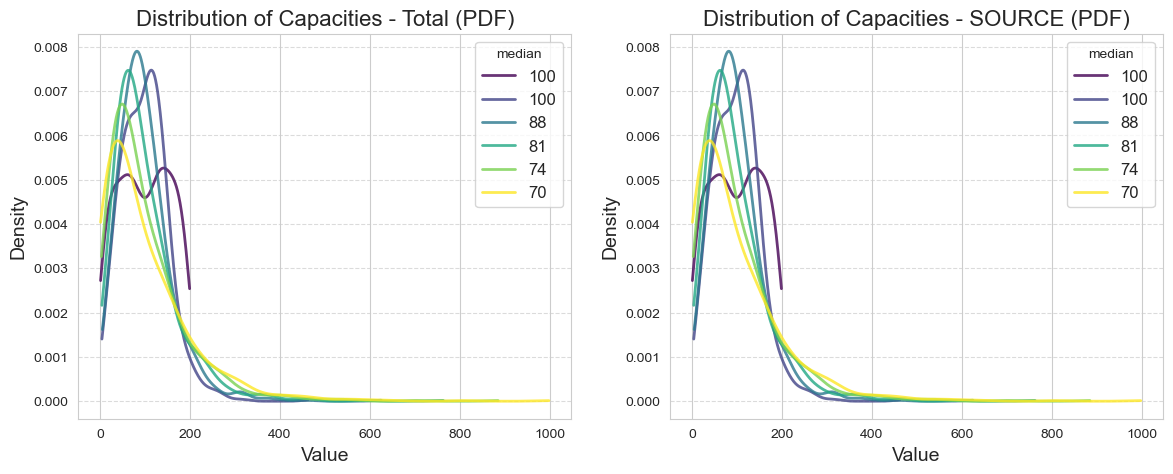

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Display the total distributions
distributions = []
medians = []
total_mean = []
sum_capacities = 0
for i, col in enumerate(capacity_columns):
    dist = prim_df[prim_df["type"] != "SINK"][col].to_numpy()
    distributions.append(dist)
    medians.append(np.median(dist))
    total_mean.append(np.mean(dist))
    sum_capacities += np.sum(dist)
    print(f"Total: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
sum_capacities = sum_capacities // len(distributions)
# Plot the PDFs
dist_colors = plt.cm.viridis(np.linspace(0, 1, len(distributions)))
plot_distributions_pdf(axes[0], distributions, dist_colors)
axes[0].set_title('Distribution of Capacities - Total (PDF)', fontsize=16)

# Display the individual distributions
for cnt_idx, type in enumerate(["SOURCE"]):
    dist_type = []
    for i, col in enumerate(capacity_columns):
        dist = prim_df[prim_df["type"] == type][col].to_numpy()
        dist_type.append(dist)
        print(f"{type}: Step {i} -> Sum: {np.sum(dist)}, Mean: {np.mean(dist):.2f}, Median: {np.median(dist):.2f}, Min: {np.min(dist):.2f}, Max: {np.max(dist):.2f}")
    # Plot the PDFs
    dist_colors = plt.cm.viridis(np.linspace(0, 1, len(dist_type)))
    plot_distributions_pdf(axes[cnt_idx+1], dist_type, dist_colors)
    axes[cnt_idx+1].set_title(f'Distribution of Capacities - {type} (PDF)', fontsize=16)

total_mean = int(np.mean(total_mean))
print("Total Mean:", total_mean)

plt.savefig("plots/sim/sim_{0}/sim_{0}_capacity_dist.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [95]:
colors, colors_hex, light_colors = util.get_color_list(opt_k)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]

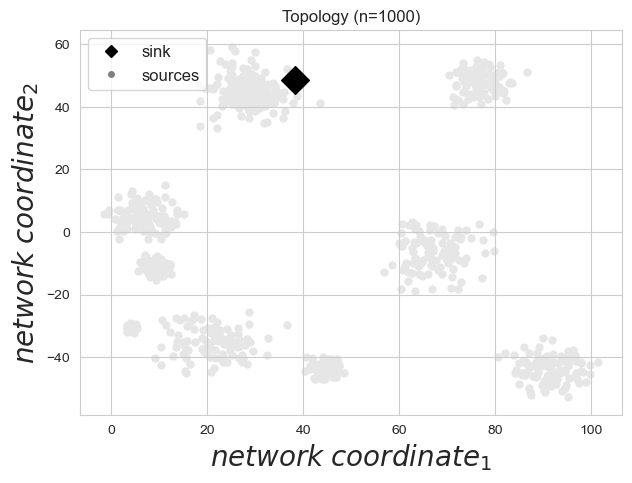

In [96]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=True, show_coordinator=True)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/sim/sim_{0}/sim_{0}_ncs.svg".format(str(device_number)), bbox_inches="tight")

plt.title(f"Topology (n={device_number})")

plt.show()

### Create Join Matrix

In [97]:
# Create a list of labels for the index and columns
source_indices = list(prim_df[prim_df["type"] == "SOURCE"].index.values)
sink_capacity = len(source_indices) * 5
input_range = [1, 75]
output_range = [1, 200]
total_sum_sources = (np.mean(input_range) * num_sources)
prim_df.loc[prim_df[prim_df["type"] == "SINK"].index, capacity_columns] = sink_capacity + 0.2*sink_capacity
print(
    f"Sources={len(source_indices)}, Sum capacities={sum_capacities}; Sum load sources={total_sum_sources}; Sum load output={sink_capacity}")

source_cardinalities = generate_random_integer_dict(source_indices, total_sum_sources, input_range[0], input_range[1],
                                                    seed=seed)
join_pairs, unassigned = create_unique_n_tuples(source_indices, 2, shuffle=False)
join_matrix_df, join_matrix, required = create_adjacency_matrix_from_pairs(prim_df.shape[0], join_pairs, output_range,
                                                           output_sum=sink_capacity, seed=seed)
print(f"Required resources for sinks:{required}")
join_matrix_df.head(10)

Sources=1000, Sum capacities=99624; Sum load sources=38000.0; Sum load output=5000
Generating n=1000 random integers between 1 and 75, sum=38000.0
Generating n=500 random integers between 1 and 200, sum=5000
Required resources for sinks:5000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

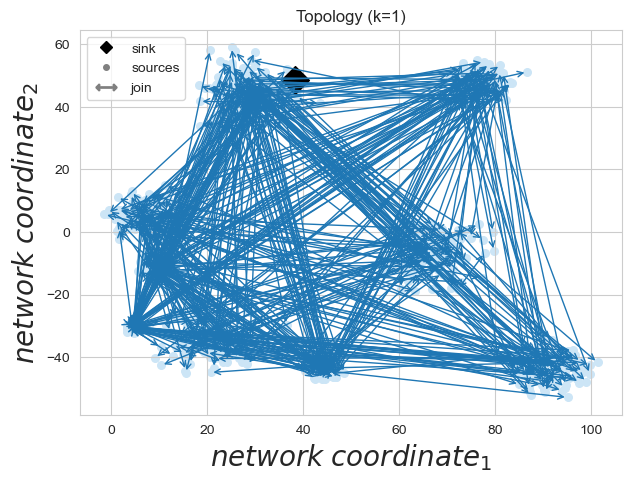

In [98]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

for i, j in join_pairs:
    if join_matrix[i, j] > 0:
        point1 = prim_df.iloc[i][coord_cols].to_numpy()
        point2 = prim_df.iloc[j][coord_cols].to_numpy()
        cluster = prim_df.loc[i, "cluster"]
        # print(i, j, point1, point2)
        arrow = FancyArrowPatch(point1, point2, arrowstyle='<->', mutation_scale=10, color=colors[cluster], linewidth=1)
        ax1.add_patch(arrow)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# Create a custom handle for the double-ended arrow line
handles = [coordinator_label, worker_label, join_label]
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(0, 1), prop={'size': 10})

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_ncs_grouped_{source_frac}.svg", bbox_inches="tight")

plt.show()

### Create Logical Plan

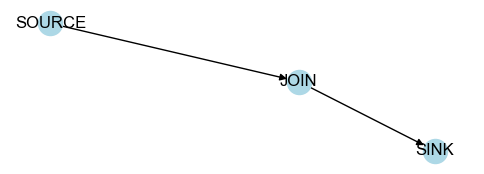

In [99]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 2))

# Create a graph
logical_plan = nx.DiGraph()

# Add nodes with labels as attributes
logical_plan.add_node(1, type=OperatorType.SOURCE)
logical_plan.add_node(2, type=OperatorType.JOIN)
logical_plan.add_node(3, type=OperatorType.SINK)

# Add edges between nodes
logical_plan.add_weighted_edges_from([(1, 2, 1), (2, 3, 1)])

# Draw the graph
pos = nx.nx_agraph.graphviz_layout(logical_plan, prog='neato')
nx.draw(logical_plan, pos, ax=ax1, with_labels=False, arrows=True, node_color='lightblue')

# Extract the labels from node attributes
labels = nx.get_node_attributes(logical_plan, 'type')

# Draw the labels on the graph
nx.draw_networkx_labels(logical_plan, pos, labels)

# Show the plot
plt.show()

## Perform Placement

### Nova

In [100]:
reduction_fac=0.4
cardinality_dict = {1: source_cardinalities, 2: (join_matrix, join_pairs)}

df_stats = None
nova_placements = {}

In [101]:
for capacity_col in eval_columns: #[eval_columns[2]]:
    if capacity_col == base_col:
        use_weight = False
    else:
        use_weight = True

    print("Starting nova placement for", capacity_col)
    pdf = prim_df.copy()
    nova = NovaSolver(pdf, logical_plan, cardinality_dict=cardinality_dict, coord_cols=coord_cols, reduction_fac=reduction_fac,
                      capacity_col=capacity_col, use_weight=use_weight, pre_knn=False)
    df_nova_it, rep_plan_it, rel_positions_it, placement_it = nova.nova_full()

    nova_placements[capacity_col] = df_nova_it, rep_plan_it, rel_positions_it, placement_it
    df_stats_it = evaluate_graph(df_nova_it, rep_plan_it)
    eval_matrix["nova_" + capacity_col] = df_stats_it.copy()

Starting nova placement for capacity_inf
Initializing Nova for 1001
Running Nova on capacity_inf
Resolving pinned operators
Resolving join operators
Preparing nodes and edges
Initializing coordinates
Computing relaxed positions for n=1501 nodes
Relaxed positions: 1501
Replicas for 1:1000
Replication count for upstream operators to 1 -> 0
Replicas for 2:500
Distributing finished: operator_id=1002 (1, 2) to n=1, opt=[73.15794057756924, -10.58662582605754], upstream_nodes=[536], additional load=0.0
Distributing finished: operator_id=1003 (3, 4) to n=1, opt=[39.63564127256426, 13.991483371245836], upstream_nodes=[61], additional load=0.0
Distributing finished: operator_id=1004 (5, 6) to n=1, opt=[23.449507389934045, 20.614168155495477], upstream_nodes=[654], additional load=0.0
Distributing finished: operator_id=1005 (7, 8) to n=1, opt=[30.602822591371922, 46.220969524329774], upstream_nodes=[29], additional load=0.0
Distributing finished: operator_id=1006 (9, 10) to n=1, opt=[33.918051625

In [102]:
for k, vals in nova_placements.items():
    df_nova, rep_plan_nova, rel_positions_nova, placement_nova = vals
    if df_nova[df_nova["free_capacity"] < 0].shape[0] > 0:
        print(f"Overloaded: {k}->{df_nova[df_nova['free_capacity'] < 0].shape[0]}")

In [103]:
plot_col = eval_columns[2]
df_nova, rep_plan_nova, rel_positions_nova, placement_nova = nova_placements[plot_col]

In [104]:
df_nova.head(10)

,x,y,type,unbalanced,weight,real_weight,total_capacity,free_capacity,level,parent
0,38.336442,48.574575,SINK,0,0,0,6000,278.4,2,[]
1,84.921652,-41.867806,SOURCE,0,10,10,127,22.0,1,"[(140, 5), (770, 5), (0, 1.0)]"
2,96.695922,-39.315084,SOURCE,0,16,32,149,149.0,0,"[(140, 16), (770, 16)]"
3,10.476383,-1.319146,SOURCE,0,68,87,121,6.0,1,"[(158, 57), (555, 19), (954, 11), (0, 0.56), (0, 1.0), (0, 17.11), (0, 6.17), (0, 0.42)]"
4,70.015674,-5.281455,SOURCE,0,30,71,125,1.0,1,"[(158, 30), (555, 11), (954, 30), (0, 0.54), (0, 0.2)]"
5,27.779656,45.519660,SOURCE,0,30,30,16,16.0,0,"[(45, 30)]"
6,4.531038,-31.322190,SOURCE,0,9,9,121,121.0,0,"[(45, 9)]"
7,28.549451,47.174656,SOURCE,0,75,75,137,48.0,1,"[(955, 75), (0, 1.0)]"
8,24.062951,43.202764,SOURCE,0,3,3,76,7.0,1,"[(955, 3), (0, 2.49), (0, 5.46)]"
9,61.821596,-15.734246,SOURCE,0,41,67,188,5.0,1,"[(860, 30), (738, 26), (178, 11), (0, 1.0), (0, 0.34), (0, 0.16)]"


In [105]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5'])

#### Replication Plan

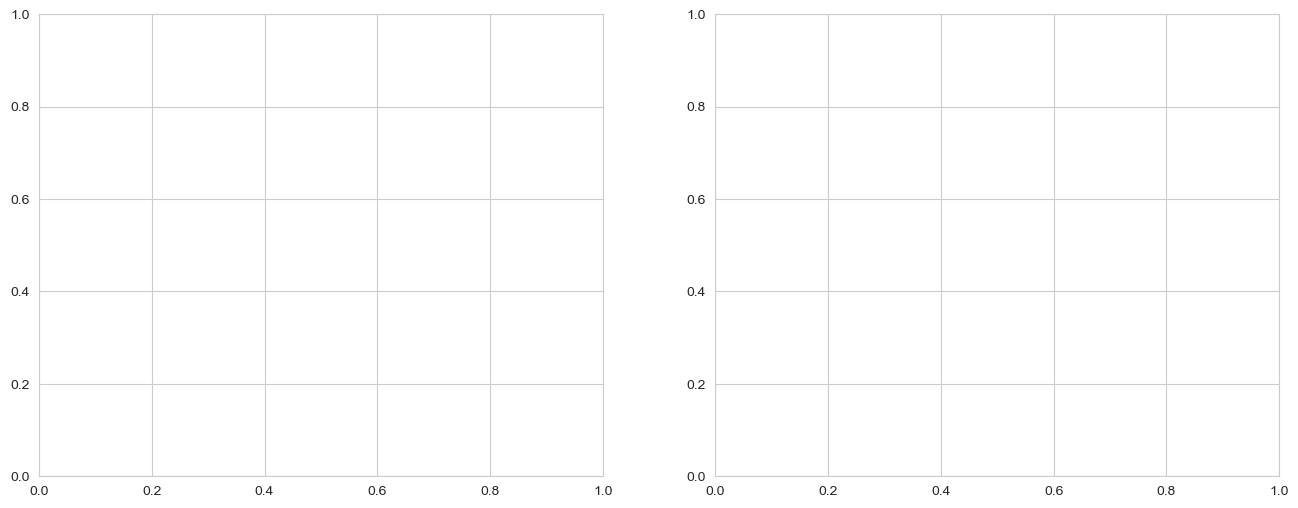

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i_ax, edge_type in enumerate(["distance", "cardinality"]):
    if num_sources > 100:
        break
    # Draw the graph
    pos = nx.nx_agraph.graphviz_layout(rep_plan_nova, prog='neato')
    nx.draw(rep_plan_nova, pos, ax=axs[i_ax], with_labels=False, arrows=True, node_color='lightblue')

    # Extract and draw node labels
    node_labels = nx.get_node_attributes(rep_plan_nova, 'type')
    nx.draw_networkx_labels(rep_plan_nova, pos, ax=axs[i_ax], labels=node_labels)

    # Extract and draw edge labels based on edge attributes
    edge_labels = nx.get_edge_attributes(rep_plan_nova, edge_type)  # Replace 'attribute_name' with your edge attribute key
    nx.draw_networkx_edge_labels(rep_plan_nova, pos, ax=axs[i_ax], edge_labels=edge_labels)
    axs[i_ax].set_title("Replication Plan: " + edge_type)

# Show the plot
plt.show()

#### Placement

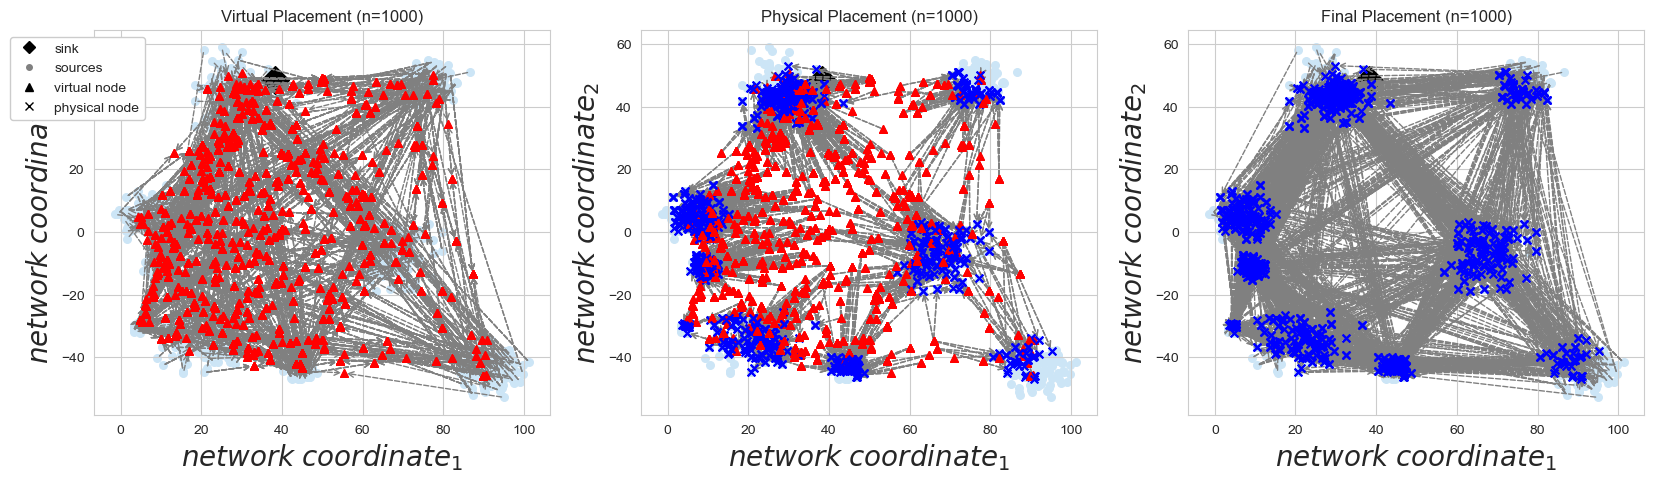

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
ax1, ax2, ax3 = axs
df_nova["cluster"] = 0

# resolve the placement
placement_coords = dict()
for key, val in placement_nova.items():
    placement_coords[key] = df_nova.loc[val, coord_cols].to_numpy()

ax1 = util.plot_topology(ax1, df_nova, colors=colors, title='Virtual Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax2 = util.plot_topology(ax2, df_nova, colors=colors, title='Physical Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)
ax3 = util.plot_topology(ax3, df_nova, colors=colors, title='Final Placement (n=' + str(device_number) + ")",
                         scale_fac=0.3, plot_voronoi=False, plot_centroid=False)

for n1, n2 in rep_plan_nova.edges:
    if n2 not in df_nova.index:
        # plot the logical nodes
        ax1.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)
        ax2.scatter(rel_positions_nova[n2][0], rel_positions_nova[n2][1], s=30, color="red", marker="^", zorder=2)

        # plot the physical nodes
        ax2.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)
        ax3.scatter(placement_coords[n2][0], placement_coords[n2][1], s=30, color="blue", marker="x", zorder=2)

    if n2 in df_nova.index:
        # arrow to the sink
        #arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="-", mutation_scale=10, color="grey", linewidth=1)
        #ax3.add_patch(arrow)
        continue
    else:
        color = "grey"
        # physical nodes -> virtual nodes
        arrow = FancyArrowPatch(rel_positions_nova[n1], rel_positions_nova[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax1.add_patch(arrow)
        #arrow = FancyArrowPatch(rel_positions[n1], rel_positions[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color=color, linewidth=1)
        #ax2.add_patch(arrow)
        # virtual node -> physical node
        arrow = FancyArrowPatch(rel_positions_nova[n2], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax2.add_patch(arrow)
        arrow = FancyArrowPatch(placement_coords[n1], placement_coords[n2], arrowstyle='->', linestyle="--",
                                mutation_scale=10, color=color, linewidth=1)
        ax3.add_patch(arrow)

    #arrow = FancyArrowPatch(placement[n1], placement[n2], arrowstyle='->', linestyle="--", mutation_scale=10, color="grey", linewidth=1)
    #ax3.add_patch(arrow)

handles = [coordinator_label, worker_label, log_opt_label, ch_label]
ax3.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(handles=handles, loc="upper left", bbox_to_anchor=(-0.2, 1), prop={'size': 10}, framealpha=1)

for ax in axs:
    ax.set_xlim(X_dim)
    ax.set_ylim(Y_dim)

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_nova_complete_{source_frac}.svg", bbox_inches="tight")
plt.show()

## Baselines

### Experiment 1: Sink-based - Placement at the Sink


In [108]:
df_stats = sink_based_placement(coord_dict, sink_indices, join_pairs, source_cardinalities)
eval_matrix["sink-based"] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.0,38000.0
1,101.0,0.0
2,105.0,0.0
3,57.0,0.0
4,62.0,0.0


### Experiment 2: Source-based - Placement at the Sources

In [109]:
df_stats = source_based_placement(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities)
eval_matrix["source-based"] = df_stats.copy()

In [110]:
df_stats.head()

,latency_distribution,received_packets
0,0.0,5000.0
1,117.0,0.0
2,105.0,10.0
3,57.0,30.0
4,116.0,0.0


### Experiment 3: Top-C - Placement at Highest Capacity Nodes

In [111]:
for capacity_col in eval_columns:
    df_stats = top_c(prim_df, coord_dict, join_matrix, join_pairs, source_cardinalities, capacity_col)
    eval_matrix["top-c_" + capacity_col] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.0,5000.0
1,128.0,73.0
2,128.0,0.0
3,116.0,0.0
4,91.0,0.0


### Experiment 3: Tree - Placement at intersections 

In [112]:
mst_coords = prim_df[coord_cols].apply(lambda row: tuple(row), axis=1).to_dict()
mst = prim_mst(mst_coords, root=0)
routes = create_routes_dict(mst)

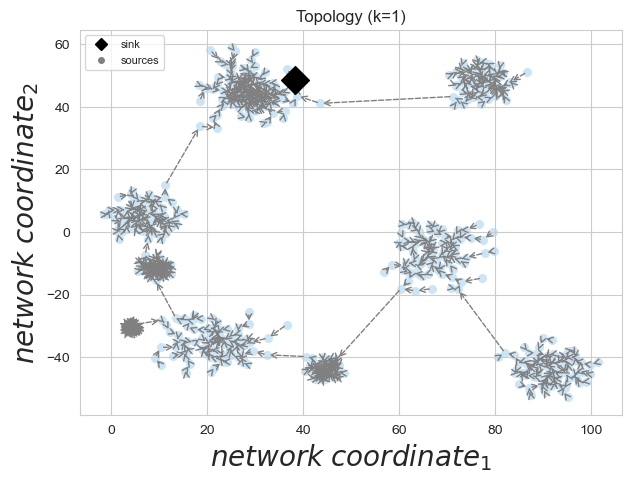

In [113]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
edge_color = "grey"

for node, parent in mst.items():
    point1 = prim_df.loc[node, coord_cols].to_numpy()
    point2 = prim_df.loc[parent, coord_cols].to_numpy()
    arrow = FancyArrowPatch(point1, point2, arrowstyle='->', linestyle="--", mutation_scale=10, color=edge_color,
                            linewidth=1)
    ax1.add_patch(arrow)

if clustering:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=True, plot_centroid=True)
else:
    ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.3,
                             plot_voronoi=False, plot_centroid=False)

ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/sim/sim_{0}/sim_{0}_mst.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [114]:
df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
eval_matrix["tree"] = df_stats.copy()
df_stats.head()

,latency_distribution,received_packets
0,0.000000,10123.0
1,263.761868,3018.0
2,280.542428,125.0
3,87.388786,74.0
4,228.298572,0.0


### Clustering - Placement at intersecting Centroids

In [115]:
num_leach_clusters = max(4, int(0.1 * device_number))

df_cl_join = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_cl_join, ch_indices, centers, u = leachSFClusteringJoin(df, capacity_col, num_leach_clusters)
    # evaluation
    routes = df_cl_join["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-sf_" + capacity_col] = df_stats.copy()

In [116]:
df_cl_join.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,38.336442,48.574575,SINK,-1,6000,NaN,[],2
1,1,84.921652,-41.867806,SOURCE,44,144,483.0,"[483, 0]",0
2,2,96.695922,-39.315084,SOURCE,29,92,884.0,"[884, 0]",0
3,3,10.476383,-1.319146,SOURCE,20,12,213.0,"[213, 0]",0
4,4,70.015674,-5.281455,SOURCE,25,53,830.0,"[830, 0]",0


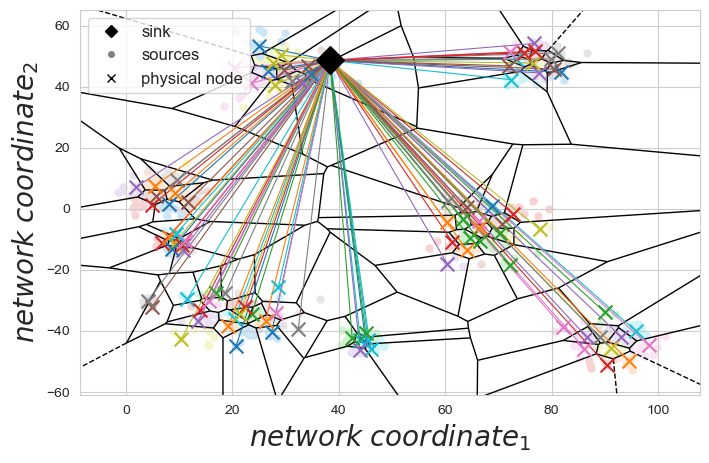

In [117]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_cl_join, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

#ax1.set_xlim(X_dim)
#ax1.set_ylim(Y_dim)

plt.savefig("plots/sim/sim_{0}/sim_{0}_clustering.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [118]:
df_stats.head()

,latency_distribution,received_packets
0,0.000000,37181.0
1,104.570329,0.0
2,106.756950,0.0
3,59.689501,0.0
4,63.306263,0.0


### Clustering+Tree - Placement at Intersecting Trees

In [119]:
num_leach_clusters = max(4, int(0.1 * device_number))
df_clTree = None

for capacity_col in eval_columns:
    df = prim_df.copy()
    df_clTree, ch_indices, centers, u = leachSFClusteringTreeJoin(df, capacity_col, num_leach_clusters, coord_cols)

    # evaluation
    routes = df_clTree["route"].to_dict()
    df_stats = evaluate_routes(prim_df, join_matrix, join_pairs, source_cardinalities, routes)
    eval_matrix["cl-tree-sf_" + capacity_col] = df_stats.copy()

In [120]:
df_clTree.head()

,oindex,x,y,type,cluster,capacity_5,parent,route,level
0,0,38.336442,48.574575,SINK,-1,6000,NaN,[],40
1,1,84.921652,-41.867806,SOURCE,38,144,869.0,"[869, 228, 875, 496, 537, 902, 507, 948, 696, 211, 478, 413, 675, 592, 853, 993, 652, 283, 136, 923, 702, 26, 854, 969, 320, 548, 964, 660, 542, 691, 907, 620, 732, 994, 890, 0]",4
2,2,96.695922,-39.315084,SOURCE,68,92,884.0,"[884, 661, 228, 875, 496, 537, 902, 507, 948, 696, 211, 478, 413, 675, 592, 853, 993, 652, 283, 136, 923, 702, 26, 854, 969, 320, 548, 964, 660, 542, 691, 907, 620, 732, 994, 890, 0]",3
3,3,10.476383,-1.319146,SOURCE,3,12,660.0,"[660, 542, 691, 907, 620, 732, 994, 890, 0]",31
4,4,70.015674,-5.281455,SOURCE,63,53,830.0,"[830, 970, 163, 119, 865, 402, 772, 700, 902, 507, 948, 696, 211, 478, 413, 675, 592, 853, 993, 652, 283, 136, 923, 702, 26, 854, 969, 320, 548, 964, 660, 542, 691, 907, 620, 732, 994, 890, 0]",1


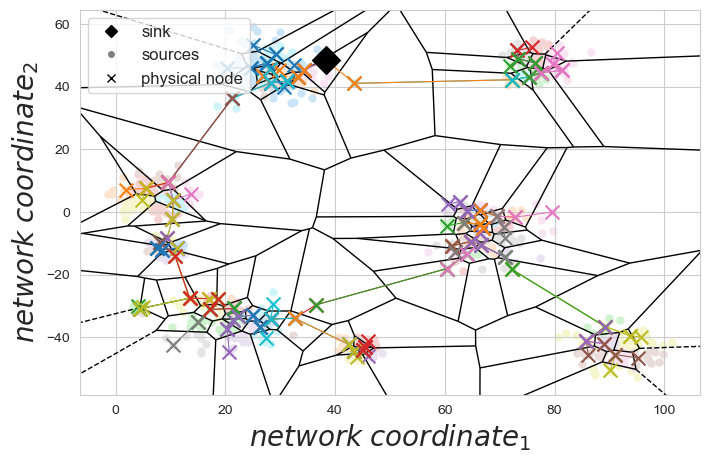

In [121]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

vor = False
if num_leach_clusters >= 4:
    vor = True
ax1 = util.plot(ax1, prim_df, df_clTree, colors=leach_colors, plot_centroids=False, plot_lines=True, plot_voronoi=vor)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

plt.savefig("plots/sim/sim_{0}/sim_{0}_clustering_tree.svg".format(str(device_number)), bbox_inches="tight")
plt.show()

In [122]:
df_stats.head()

,latency_distribution,received_packets
0,0.000000,15795.0
1,213.019645,0.0
2,214.779942,0.0
3,63.584737,0.0
4,192.832405,0.0


## Evaluation

In [123]:
homogeneous = ['sink-based', 'source-based', 'tree']
heterogeneous = ["cl-sf", "cl-tree-sf", "top-c"] + ["nova"]

In [124]:
eval_matrix.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

### Latency

In [125]:
capacity_col = "capacity_inf"

In [137]:
approach_order = get_approaches()
eval_colors = get_eval_colors_dict()
markers = get_markers_dict()
styles = get_styles_dict()

sink-based sink-based
source-based source-based
top-c_capacity_inf top-c
tree tree
cl-sf_capacity_inf cl-sf
cl-tree-sf_capacity_inf cl-tree-sf
nova_capacity_inf nova


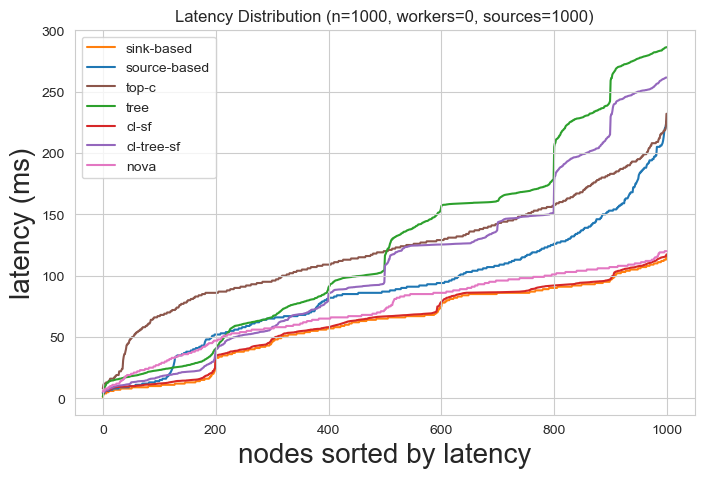

Means:  {'sink-based': np.float64(61.02), 'source-based': np.float64(88.46), 'top-c': np.float64(120.54), 'tree': np.float64(125.12), 'cl-sf': np.float64(62.71), 'cl-tree-sf': np.float64(109.0), 'nova': np.float64(72.38)}
Quantiles:  {'sink-based': np.float64(96.1), 'source-based': np.float64(153.0), 'top-c': np.float64(183.0), 'tree': np.float64(243.99), 'cl-sf': np.float64(96.89), 'cl-tree-sf': np.float64(216.37), 'nova': np.float64(107.0)}


In [129]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for label in approach_order:
    if label in homogeneous:
        l = label
    else:
        l = label + "_" + capacity_col

    print(l, label)
    eval_df = eval_matrix[l]["latency_distribution"][eval_matrix[l]["latency_distribution"] > 0]
    sv = eval_df.sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[label] = round(eval_df.quantile(0.9), 2)
    mean_dict[label] = round(eval_df.mean(), 2)
    if label == "nova":
        zorder = 100
    else:
        zorder = 0
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=label, color=eval_colors[label], zorder=zorder)

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/sim/sim_{0}/sim_{0}_eval_latency.svg".format(str(device_number)), bbox_inches="tight")

ax1.set_title(f'Latency Distribution (n={device_number}, workers={num_workers}, sources={num_sources})')
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

### Heterogeneity

In [138]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.keys()

dict_keys(['nova_capacity_inf', 'nova_capacity_0', 'nova_capacity_1', 'nova_capacity_2', 'nova_capacity_3', 'nova_capacity_4', 'nova_capacity_5', 'sink-based', 'source-based', 'top-c_capacity_inf', 'top-c_capacity_0', 'top-c_capacity_1', 'top-c_capacity_2', 'top-c_capacity_3', 'top-c_capacity_4', 'top-c_capacity_5', 'tree', 'cl-sf_capacity_inf', 'cl-sf_capacity_0', 'cl-sf_capacity_1', 'cl-sf_capacity_2', 'cl-sf_capacity_3', 'cl-sf_capacity_4', 'cl-sf_capacity_5', 'cl-tree-sf_capacity_inf', 'cl-tree-sf_capacity_0', 'cl-tree-sf_capacity_1', 'cl-tree-sf_capacity_2', 'cl-tree-sf_capacity_3', 'cl-tree-sf_capacity_4', 'cl-tree-sf_capacity_5'])

In [139]:
load_dict = {}
load_norm_dict = {}
nn_dict = {}

for k in approach_order:
    slot_list = []
    slot_list_norm = []
    nn_list = []
    for colname in capacity_columns:
        if k in homogeneous:
            df = eval_matrix_load[k]
        else:
            df = eval_matrix_load[k + "_" + colname]
        df["av_capacity"] = prim_df[colname] - df["received_packets"]
        agg_nodes = df["received_packets"][df["received_packets"] > 0].count()
        tmp_df_sl = df[df["av_capacity"] < 0]
        tmp_df_nn = df[df["av_capacity"] >= 0]
        slot_list.append(tmp_df_sl["av_capacity"].count())
        slot_list_norm.append(int((tmp_df_sl["av_capacity"].count() / agg_nodes) * 100))
        nn_list.append(tmp_df_nn["av_capacity"].count())
    load_dict[k] = slot_list
    load_norm_dict[k] = slot_list_norm
    nn_dict[k] = nn_list

In [140]:
load_dict.keys()

dict_keys(['sink-based', 'source-based', 'top-c', 'tree', 'cl-sf', 'cl-tree-sf', 'nova'])

In [141]:
agg_arr1 = []
for fam in load_dict.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
    print(load_norm_dict[fam])

Fam:  sink-based
[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
[100, 100, 100, 100, 100, 100]
Fam:  source-based
[np.int64(70), np.int64(43), np.int64(43), np.int64(55), np.int64(76), np.int64(116)]
[13, 8, 8, 10, 15, 23]
Fam:  top-c
[np.int64(7), np.int64(22), np.int64(22), np.int64(11), np.int64(1), np.int64(0)]
[1, 5, 6, 3, 0, 0]
Fam:  tree
[np.int64(620), np.int64(615), np.int64(612), np.int64(614), np.int64(622), np.int64(627)]
[79, 78, 78, 78, 79, 80]
Fam:  cl-sf
[np.int64(84), np.int64(86), np.int64(85), np.int64(87), np.int64(89), np.int64(93)]
[87, 87, 85, 88, 89, 95]
Fam:  cl-tree-sf
[np.int64(97), np.int64(96), np.int64(90), np.int64(98), np.int64(98), np.int64(98)]
[97, 95, 90, 97, 98, 98]
Fam:  nova
[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]
[0, 0, 0, 0, 0, 0]


sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [np.int64(70), np.int64(43), np.int64(43), np.int64(55), np.int64(76), np.int64(116)]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [np.int64(7), np.int64(22), np.int64(22), np.int64(11), np.int64(1), np.int64(0)]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [np.int64(620), np.int64(615), np.int64(612), np.int64(614), np.int64(622), np.int64(627)]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [np.int64(84), np.int64(86), np.int64(85), np.int64(87), np.int64(89), np.int64(93)]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [np.int64(97), np.int64(96), np.int64(90), np.int64(98), np.int64(98), np.int64(98)]
nova (0, (3, 1, 1, 1)) * (0.890196078431372

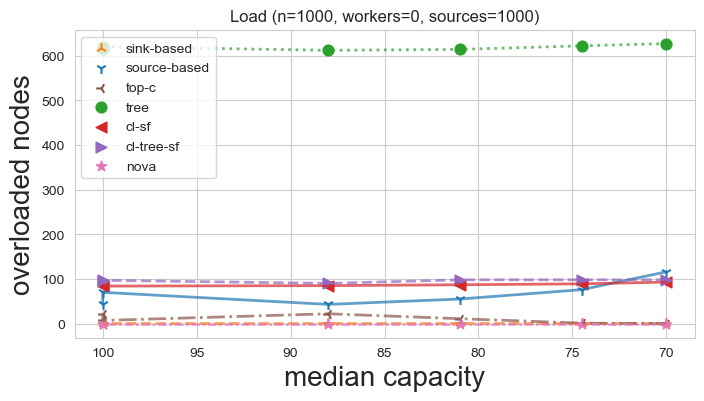

In [142]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

medians_plot = medians

for fam in load_dict.keys():
    vals = load_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend(loc="upper left", prop={'size': 10})

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_eval_load_abs_{source_frac}.svg", bbox_inches="tight")
ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

sink-based -- 2 (1.0, 0.4980392156862745, 0.054901960784313725) : [100, 100, 100, 100, 100, 100]
source-based - 1 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) : [13, 8, 8, 10, 15, 23]
top-c -. 3 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354) : [1, 5, 6, 3, 0, 0]
tree : o (0.17254901960784313, 0.6274509803921569, 0.17254901960784313) : [79, 78, 78, 78, 79, 80]
cl-sf - < (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) : [87, 87, 85, 88, 89, 95]
cl-tree-sf -- > (0.5803921568627451, 0.403921568627451, 0.7411764705882353) : [97, 95, 90, 97, 98, 98]
nova (0, (3, 1, 1, 1)) * (0.8901960784313725, 0.4666666666666667, 0.7607843137254902) : [0, 0, 0, 0, 0, 0]


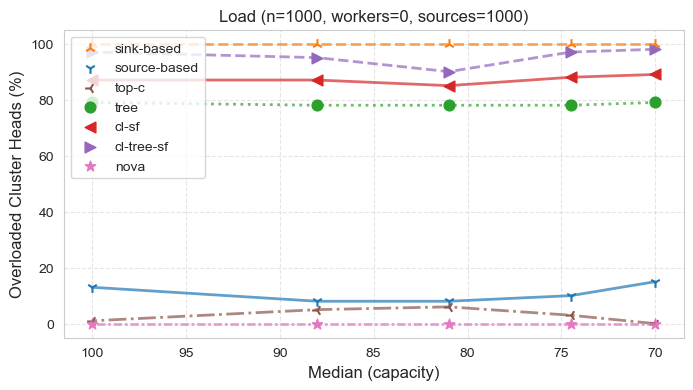

In [144]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

medians_plot = medians[1:]

for fam in load_norm_dict.keys():
    vals = load_norm_dict[fam]
    print(fam, styles[fam], markers[fam], eval_colors[fam], ":", vals)

    # Ensure data is sorted for a proper line plot
    sorted_indices = np.argsort(medians_plot)
    medians_sorted = np.array(medians_plot)[sorted_indices]
    vals_sorted = np.array(vals)[sorted_indices]

    # Plot the scatter points
    ax.scatter(medians_sorted, vals_sorted, marker=markers[fam], color=eval_colors[fam], label=fam, s=60)
    # Plot the line with the desired linestyle
    ax.plot(medians_sorted, vals_sorted, linestyle=styles[fam], color=eval_colors[fam], linewidth=2, alpha=0.7)

ax.invert_xaxis()
ax.set_xlabel("Median (capacity)", fontsize=12)
ax.set_ylabel("Overloaded Cluster Heads (%)", fontsize=12)
ax.legend(loc="upper left")
ax.grid(visible=True, linestyle='--', alpha=0.5)

plt.savefig(f"plots/sim/sim_{device_number}/sim_{device_number}_eval_load_perc_{source_frac}.svg", bbox_inches="tight")

ax.set_title(f"Load (n={device_number}, workers={num_workers}, sources={num_sources})")
plt.show()

In [145]:
quant_dict

{'sink-based': np.float64(96.1),
 'source-based': np.float64(153.0),
 'top-c': np.float64(183.0),
 'tree': np.float64(243.99),
 'cl-sf': np.float64(96.89),
 'cl-tree-sf': np.float64(216.37),
 'nova': np.float64(107.0)}

In [146]:
mean_dict

{'sink-based': np.float64(61.02),
 'source-based': np.float64(88.46),
 'top-c': np.float64(120.54),
 'tree': np.float64(125.12),
 'cl-sf': np.float64(62.71),
 'cl-tree-sf': np.float64(109.0),
 'nova': np.float64(72.38)}